<big>First setp is to train the dinov2 classifier with labeled data</big>

*Pre requirement:*

*pip install torch torchvision timm scikit-learn*


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Using device: cuda


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]


Starting experiment: dinov2_1_generated_from_augmentation
Positive folder: 1_generated_from_augmentation
Found 5000 negative images (class 0)
Found 3223 positive images (class 1)
Train size: 6578, Val size: 1645


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]


Epoch 1/30


Train  - loss: 0.5348, acc: 0.7431
Val    - loss: 0.4120, acc: 0.7909, P1: 0.8090, R1: 0.6109, F1: 0.6961

Epoch 2/30


Train  - loss: 0.3801, acc: 0.8325
Val    - loss: 0.3513, acc: 0.8480, P1: 0.8805, R1: 0.7085, F1: 0.7852

Epoch 3/30


Train  - loss: 0.3466, acc: 0.8525
Val    - loss: 0.4088, acc: 0.8164, P1: 0.9501, R1: 0.5612, F1: 0.7057

Epoch 4/30


Train  - loss: 0.3540, acc: 0.8489
Val    - loss: 0.3893, acc: 0.8207, P1: 0.8772, R1: 0.6310, F1: 0.7340

Epoch 5/30


Train  - loss: 0.3312, acc: 0.8544
Val    - loss: 0.3612, acc: 0.8681, P1: 0.8963, R1: 0.7504, F1: 0.8169

Epoch 6/30


Train  - loss: 0.3087, acc: 0.8676
Val    - loss: 0.3357, acc: 0.8498, P1: 0.8080, R1: 0.8093, F1: 0.8087

Epoch 7/30


Train  - loss: 0.2936, acc: 0.8794
Val    - loss: 0.2781, acc: 0.8790, P1: 0.8574, R1: 0.8295, F1: 0.8432

Epoch 8/30


Train  - loss: 0.2847, acc: 0.8863
Val    - loss: 0.2810, acc: 0.8754, P1: 0.8679, R1: 0.8047, F1: 0.8351

Epoch 9/30


Train  - loss: 0.3097, acc: 0.8731
Val    - loss: 0.2991, acc: 0.8711, P1: 0.8590, R1: 0.8031, F1: 0.8301

Epoch 10/30


Train  - loss: 0.2797, acc: 0.8851
Val    - loss: 0.2825, acc: 0.8717, P1: 0.8861, R1: 0.7721, F1: 0.8252

Epoch 11/30


Train  - loss: 0.2687, acc: 0.8902
Val    - loss: 0.2726, acc: 0.8815, P1: 0.8549, R1: 0.8403, F1: 0.8475

Epoch 12/30


Train  - loss: 0.2655, acc: 0.8880
Val    - loss: 0.3109, acc: 0.8687, P1: 0.9165, R1: 0.7318, F1: 0.8138

Epoch 13/30


Train  - loss: 0.2495, acc: 0.8948
Val    - loss: 0.2681, acc: 0.8839, P1: 0.8309, R1: 0.8837, F1: 0.8565

Epoch 14/30


Train  - loss: 0.2366, acc: 0.9036
Val    - loss: 0.2985, acc: 0.8839, P1: 0.8261, R1: 0.8915, F1: 0.8576

Epoch 15/30


Train  - loss: 0.2556, acc: 0.8937
Val    - loss: 0.3736, acc: 0.8505, P1: 0.8829, R1: 0.7132, F1: 0.7890

Epoch 16/30


Train  - loss: 0.2374, acc: 0.9030
Val    - loss: 0.2893, acc: 0.8742, P1: 0.8662, R1: 0.8031, F1: 0.8335

Epoch 17/30


Train  - loss: 0.2337, acc: 0.9083
Val    - loss: 0.2983, acc: 0.8705, P1: 0.7959, R1: 0.9008, F1: 0.8451

Epoch 18/30


Train  - loss: 0.2274, acc: 0.9106
Val    - loss: 0.2717, acc: 0.8881, P1: 0.8712, R1: 0.8388, F1: 0.8547

Epoch 19/30


Train  - loss: 0.2217, acc: 0.9111
Val    - loss: 0.2971, acc: 0.8669, P1: 0.7886, R1: 0.9023, F1: 0.8416

Epoch 20/30


Train  - loss: 0.2215, acc: 0.9076
Val    - loss: 0.2774, acc: 0.8863, P1: 0.8855, R1: 0.8155, F1: 0.8491

Epoch 21/30


Train  - loss: 0.2132, acc: 0.9138
Val    - loss: 0.2700, acc: 0.8784, P1: 0.8803, R1: 0.7984, F1: 0.8374

Epoch 22/30


Train  - loss: 0.2105, acc: 0.9156
Val    - loss: 0.2788, acc: 0.8960, P1: 0.8475, R1: 0.8961, F1: 0.8711

Epoch 23/30


Train  - loss: 0.1989, acc: 0.9164
Val    - loss: 0.2608, acc: 0.8918, P1: 0.8712, R1: 0.8496, F1: 0.8603

Epoch 24/30


Train  - loss: 0.1866, acc: 0.9269
Val    - loss: 0.2799, acc: 0.8821, P1: 0.8245, R1: 0.8884, F1: 0.8552

Epoch 25/30


Train  - loss: 0.1841, acc: 0.9264
Val    - loss: 0.2651, acc: 0.8967, P1: 0.8992, R1: 0.8295, F1: 0.8629

Epoch 26/30


Train  - loss: 0.1854, acc: 0.9258
Val    - loss: 0.2633, acc: 0.8894, P1: 0.8589, R1: 0.8589, F1: 0.8589

Epoch 27/30


Train  - loss: 0.1827, acc: 0.9295
Val    - loss: 0.2746, acc: 0.8967, P1: 0.8467, R1: 0.8992, F1: 0.8722

Epoch 28/30


Train  - loss: 0.1712, acc: 0.9339
Val    - loss: 0.3754, acc: 0.8657, P1: 0.9093, R1: 0.7302, F1: 0.8100

Epoch 29/30


Train  - loss: 0.1684, acc: 0.9349
Val    - loss: 0.3139, acc: 0.8954, P1: 0.8546, R1: 0.8837, F1: 0.8689

Epoch 30/30


Train  - loss: 0.1678, acc: 0.9395
Val    - loss: 0.2851, acc: 0.8857, P1: 0.8764, R1: 0.8248, F1: 0.8498



--------------------------------------------------------------------------------
Final validation metrics for dinov2_1_generated_from_augmentation:
Loss: 0.2851
Accuracy: 0.8857
P1 (Precision for class 1): 0.8764
R1 (Recall for class 1):    0.8248
F1 (F1 for class 1):        0.8498
--------------------------------------------------------------------------------


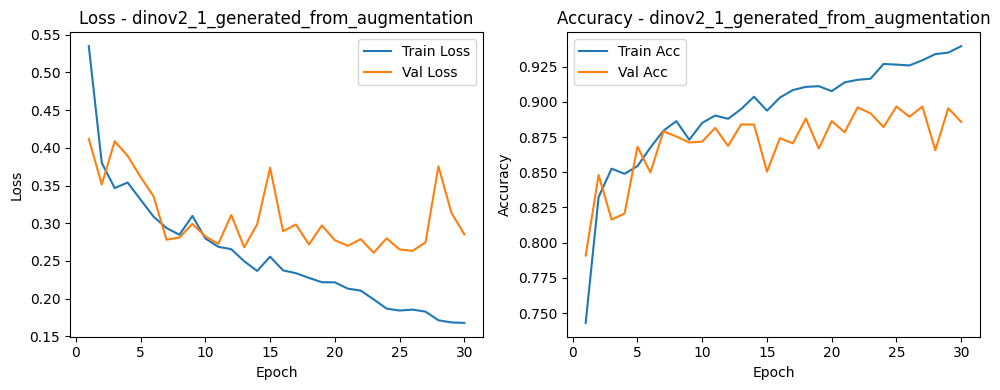

Saved model + processor to: /content/drive/MyDrive/Colab Notebooks/Course/Skin_Cancer_Classification/models/dinov2_1_generated_from_augmentation

Starting experiment: dinov2_1_generated_from_unlabeled
Positive folder: 1_generated from unlabeled
Found 5000 negative images (class 0)
Found 2997 positive images (class 1)
Train size: 6397, Val size: 1600

Epoch 1/30


Train  - loss: 0.6222, acc: 0.6720
Val    - loss: 0.5189, acc: 0.7488, P1: 0.7335, R1: 0.5183, F1: 0.6074

Epoch 2/30


Train  - loss: 0.5167, acc: 0.7461
Val    - loss: 0.6838, acc: 0.6994, P1: 0.8362, R1: 0.2467, F1: 0.3810

Epoch 3/30


Train  - loss: 0.4617, acc: 0.7877
Val    - loss: 0.4361, acc: 0.7900, P1: 0.6924, R1: 0.7917, F1: 0.7387

Epoch 4/30


Train  - loss: 0.4329, acc: 0.8040
Val    - loss: 0.4532, acc: 0.7963, P1: 0.6700, R1: 0.9000, F1: 0.7681

Epoch 5/30


Train  - loss: 0.4157, acc: 0.8130
Val    - loss: 0.4323, acc: 0.7906, P1: 0.6929, R1: 0.7933, F1: 0.7397

Epoch 6/30


Train  - loss: 0.4157, acc: 0.8171
Val    - loss: 0.4295, acc: 0.7881, P1: 0.8254, R1: 0.5517, F1: 0.6613

Epoch 7/30


Train  - loss: 0.3999, acc: 0.8227
Val    - loss: 0.4521, acc: 0.7919, P1: 0.7883, R1: 0.6083, F1: 0.6867

Epoch 8/30


Train  - loss: 0.4030, acc: 0.8234
Val    - loss: 0.3996, acc: 0.8250, P1: 0.7817, R1: 0.7400, F1: 0.7603

Epoch 9/30


Train  - loss: 0.3902, acc: 0.8310
Val    - loss: 0.4030, acc: 0.8119, P1: 0.7127, R1: 0.8350, F1: 0.7690

Epoch 10/30


Train  - loss: 0.3821, acc: 0.8365
Val    - loss: 0.3906, acc: 0.8219, P1: 0.7578, R1: 0.7717, F1: 0.7647

Epoch 11/30


Train  - loss: 0.3819, acc: 0.8334
Val    - loss: 0.4164, acc: 0.8056, P1: 0.6904, R1: 0.8733, F1: 0.7712

Epoch 12/30


Train  - loss: 0.3690, acc: 0.8410
Val    - loss: 0.3787, acc: 0.8369, P1: 0.7858, R1: 0.7767, F1: 0.7812

Epoch 13/30


Train  - loss: 0.3614, acc: 0.8443
Val    - loss: 0.3906, acc: 0.8263, P1: 0.7805, R1: 0.7467, F1: 0.7632

Epoch 14/30


Train  - loss: 0.3557, acc: 0.8443
Val    - loss: 0.4181, acc: 0.8300, P1: 0.7867, R1: 0.7500, F1: 0.7679

Epoch 15/30


Train  - loss: 0.3537, acc: 0.8454
Val    - loss: 0.3784, acc: 0.8344, P1: 0.7460, R1: 0.8467, F1: 0.7931

Epoch 16/30


Train  - loss: 0.3406, acc: 0.8567
Val    - loss: 0.3676, acc: 0.8394, P1: 0.7902, R1: 0.7783, F1: 0.7842

Epoch 17/30


Train  - loss: 0.3289, acc: 0.8585
Val    - loss: 0.3705, acc: 0.8281, P1: 0.8083, R1: 0.7100, F1: 0.7560

Epoch 18/30


Train  - loss: 0.3220, acc: 0.8640
Val    - loss: 0.4295, acc: 0.8063, P1: 0.8519, R1: 0.5850, F1: 0.6937

Epoch 19/30


Train  - loss: 0.3207, acc: 0.8659
Val    - loss: 0.3860, acc: 0.8213, P1: 0.7145, R1: 0.8717, F1: 0.7853

Epoch 20/30


Train  - loss: 0.3145, acc: 0.8660
Val    - loss: 0.4028, acc: 0.8094, P1: 0.8132, R1: 0.6383, F1: 0.7152

Epoch 21/30


Train  - loss: 0.3008, acc: 0.8773
Val    - loss: 0.3829, acc: 0.8219, P1: 0.7203, R1: 0.8583, F1: 0.7833

Epoch 22/30


Train  - loss: 0.3047, acc: 0.8709
Val    - loss: 0.4634, acc: 0.7894, P1: 0.7195, R1: 0.7183, F1: 0.7189

Epoch 23/30


Train  - loss: 0.3025, acc: 0.8726
Val    - loss: 0.3766, acc: 0.8337, P1: 0.7352, R1: 0.8700, F1: 0.7969

Epoch 24/30


Train  - loss: 0.2938, acc: 0.8774
Val    - loss: 0.3955, acc: 0.8281, P1: 0.7787, R1: 0.7567, F1: 0.7675

Epoch 25/30


Train  - loss: 0.2899, acc: 0.8806
Val    - loss: 0.3721, acc: 0.8337, P1: 0.7860, R1: 0.7650, F1: 0.7753

Epoch 26/30


Train  - loss: 0.2803, acc: 0.8864
Val    - loss: 0.4138, acc: 0.8225, P1: 0.7194, R1: 0.8633, F1: 0.7848

Epoch 27/30


Train  - loss: 0.2860, acc: 0.8812
Val    - loss: 0.3650, acc: 0.8456, P1: 0.7908, R1: 0.8000, F1: 0.7954

Epoch 28/30


Train  - loss: 0.2722, acc: 0.8867
Val    - loss: 0.3879, acc: 0.8387, P1: 0.7697, R1: 0.8133, F1: 0.7909

Epoch 29/30


Train  - loss: 0.3010, acc: 0.8720
Val    - loss: 0.3900, acc: 0.8369, P1: 0.7858, R1: 0.7767, F1: 0.7812

Epoch 30/30


Train  - loss: 0.2733, acc: 0.8876
Val    - loss: 0.3799, acc: 0.8337, P1: 0.8199, R1: 0.7133, F1: 0.7629



--------------------------------------------------------------------------------
Final validation metrics for dinov2_1_generated_from_unlabeled:
Loss: 0.3799
Accuracy: 0.8337
P1 (Precision for class 1): 0.8199
R1 (Recall for class 1):    0.7133
F1 (F1 for class 1):        0.7629
--------------------------------------------------------------------------------


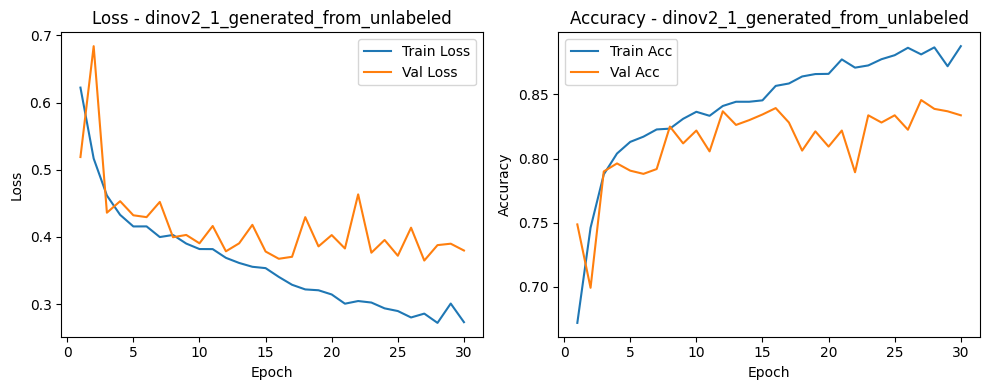

Saved model + processor to: /content/drive/MyDrive/Colab Notebooks/Course/Skin_Cancer_Classification/models/dinov2_1_generated_from_unlabeled

All experiments finished.


In [4]:
# ============================================
# 0. Install deps (run once per new runtime)
# ============================================
!pip install -q transformers scikit-learn

# ============================================
# 1. Imports & setup
# ============================================
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers import Dinov2Config, Dinov2ForImageClassification, AutoImageProcessor


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================
# 2. Paths & experiment definitions
# ============================================
MAIN_DIR = "/content/drive/MyDrive/Colab Notebooks/Course/Skin_Cancer_Classification"

EXPERIMENTS = [
    {
        "pos_folder": "1_generated_from_augmentation",
        "exp_name": "dinov2_1_generated_from_augmentation"
    },
    {
        "pos_folder": "1_generated from unlabeled",  # note the space
        "exp_name": "dinov2_1_generated_from_unlabeled"
    }
]

SAVE_MODELS_DIR = os.path.join(MAIN_DIR, "models")
os.makedirs(SAVE_MODELS_DIR, exist_ok=True)

# ============================================
# 3. Image processor for DINOv2
#    (only config & preprocessing, NO weights)
# ============================================
# We re-use the official DINOv2 image processor to get
# correct resize/normalization, but the model itself will
# be created from a config (random weights).
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

# ============================================
# 4. Dataset definition
# ============================================
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

class SkinCancerDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        # pixel_values shape: [1, 3, H, W] -> [3, H, W]
        pixel_values = inputs["pixel_values"].squeeze(0)

        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(label, dtype=torch.long)
        }

def collect_image_paths(folder):
    paths = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(IMG_EXTENSIONS):
                paths.append(os.path.join(root, f))
    return paths

# ============================================
# 5. Training & evaluation helpers
# ============================================
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc="Train", leave=False):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits  # [B, 2]

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    return avg_loss, acc

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Val", leave=False):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)

            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples

    # Binary metrics for positive class = 1
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="binary", pos_label=1, zero_division=0
    )

    return avg_loss, acc, precision, recall, f1

def plot_curves(train_losses, val_losses, train_accs, val_accs, exp_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - {exp_name}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - {exp_name}")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ============================================
# 6. Main training loop for each experiment
# ============================================
NUM_EPOCHS = 30
BATCH_SIZE = 16   # adjust if you see OOM
LR = 1e-4
VAL_SPLIT = 0.2   # 80% train / 20% val

for cfg in EXPERIMENTS:
    pos_folder = cfg["pos_folder"]
    exp_name = cfg["exp_name"]

    print("\n" + "="*80)
    print(f"Starting experiment: {exp_name}")
    print(f"Positive folder: {pos_folder}")
    print("="*80)

    # 1) Collect image paths
    neg_dir = os.path.join(MAIN_DIR, "0")
    pos_dir = os.path.join(MAIN_DIR, pos_folder)

    neg_images = collect_image_paths(neg_dir)
    pos_images = collect_image_paths(pos_dir)

    print(f"Found {len(neg_images)} negative images (class 0)")
    print(f"Found {len(pos_images)} positive images (class 1)")

    all_paths = neg_images + pos_images
    all_labels = [0] * len(neg_images) + [1] * len(pos_images)

    # 2) Train/val split (stratified)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_paths,
        all_labels,
        test_size=VAL_SPLIT,
        random_state=SEED,
        stratify=all_labels,
    )

    print(f"Train size: {len(train_paths)}, Val size: {len(val_paths)}")

    # 3) Build datasets & loaders
    train_dataset = SkinCancerDataset(train_paths, train_labels, processor)
    val_dataset = SkinCancerDataset(val_paths, val_labels, processor)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # 4) Initialize DINOv2 model from CONFIG (NO pretrained weights)
    config = Dinov2Config.from_pretrained(
    "facebook/dinov2-small",
    num_labels=2
)
    # we still initialize RANDOM weights (no pretrained checkpoint)
    model = Dinov2ForImageClassification(config)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    # 5) Training loop
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Train  - loss: {train_loss:.4f}, acc: {train_acc:.4f}\n"
            f"Val    - loss: {val_loss:.4f}, acc: {val_acc:.4f}, "
            f"P1: {val_prec:.4f}, R1: {val_rec:.4f}, F1: {val_f1:.4f}"
        )

    # 6) Final evaluation on val set
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion)
    print("\n" + "-"*80)
    print(f"Final validation metrics for {exp_name}:")
    print(f"Loss: {val_loss:.4f}")
    print(f"Accuracy: {val_acc:.4f}")
    print(f"P1 (Precision for class 1): {val_prec:.4f}")
    print(f"R1 (Recall for class 1):    {val_rec:.4f}")
    print(f"F1 (F1 for class 1):        {val_f1:.4f}")
    print("-"*80)

    # 7) Plot curves
    plot_curves(train_losses, val_losses, train_accs, val_accs, exp_name)

    # 8) Save model & processor for later predictions
    save_dir = os.path.join(SAVE_MODELS_DIR, exp_name)
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)
    processor.save_pretrained(save_dir)

    print(f"Saved model + processor to: {save_dir}")

print("\nAll experiments finished.")
